In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os

# Đường dẫn đến file CSV
data_path = Path("van_ban_summary.csv")  # Thay thế đường dẫn thực tế của bạn

# Kiểm tra xem file tồn tại
if data_path.exists():
    print(f"File tồn tại: {data_path}")
    
    # Đọc dữ liệu
    df = pd.read_csv(data_path)
    
    # Hiển thị thông tin cơ bản về dữ liệu
    print("Kích thước dữ liệu:", df.shape)
    print("\n5 dòng đầu tiên:")
    print(df.head())
    
    # Thông tin cột
    print("\nThông tin các cột:")
    print(df.info())
    
    # Thống kê mô tả
    print("\nThống kê mô tả:")
    print(df.describe())
    
    # Kiểm tra giá trị null
    print("\nKiểm tra giá trị null:")
    print(df.isnull().sum())
else:
    print(f"File không tồn tại: {data_path}")

File tồn tại: van_ban_summary.csv
Kích thước dữ liệu: (1236, 5)

5 dòng đầu tiên:
                         Tiêu đề            Số hiệu  \
0            CHÍNH\n  PHỦ-------  Số: 18/2025/NĐ-CP   
1              BỘ\n  Y TẾ-------      Số: 04/CT-BYT   
2  THỦ TƯỚNG CHÍNH\n  PHỦ-------      Số: 10/CĐ-TTg   
3                 Không tìm thấy     Không tìm thấy   
4                 Không tìm thấy     Không tìm thấy   

                          Ngày ban hành  \
0     Hà Nội, ngày 08 tháng 02 năm 2025   
1  Hà Nội, ngày 07\n  tháng 02 năm 2025   
2  Hà Nội, ngày 07\n  tháng 02 năm 2025   
3                        Không tìm thấy   
4                        Không tìm thấy   

                                             Tóm tắt  \
0  Theo Nghị định 18/2025/NĐ-CP, quy định về bảo ...   
1  Sứ mệnh của THƯ VIỆN PHÁP LUẬT là:\n\n*   Sử d...   
2  Để tiếp tục nâng cao chất lượng, hiệu quả quản...   
3  Sứ mệnh của THƯ VIỆN PHÁP LUẬT là:\n* sử dụng ...   
4  Sứ mệnh của THƯ VIỆN PHÁP LUẬT là: sử dụng cô

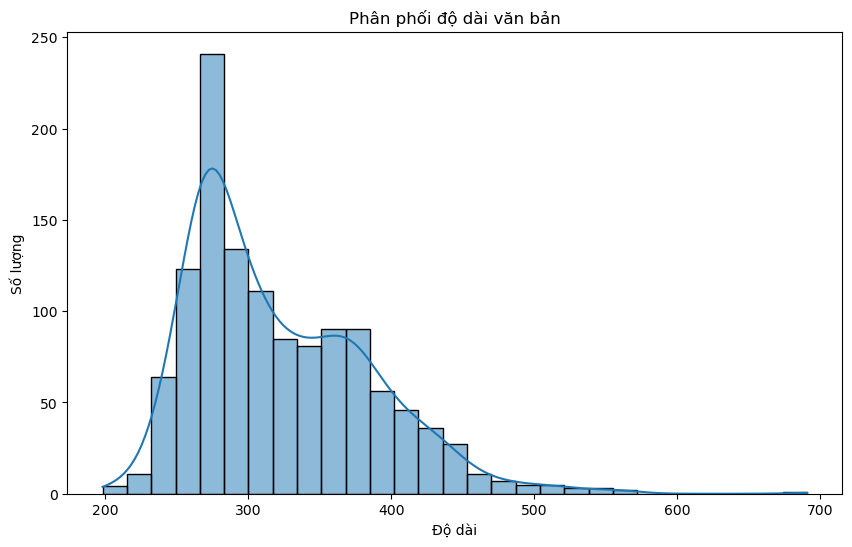

Độ dài văn bản trung bình: 321.73 ký tự
Độ dài văn bản ngắn nhất: 198 ký tự
Độ dài văn bản dài nhất: 691 ký tự


In [6]:
import re
import nltk
from nltk.corpus import stopwords

#Load stopwords từ file txt
vietnamese_stopwords = open('vietnamese-stopwords.txt', 'r').read().splitlines()


def clean_text(text):
    """Hàm làm sạch văn bản"""
    if isinstance(text, str):
        # Chuyển về chữ thường
        text = text.lower()
        
        # Loại bỏ các ký tự đặc biệt
        text = re.sub(r'[^\w\s]', '', text)
        
        # Loại bỏ số
        text = re.sub(r'\d+', '', text)
        
        # Loại bỏ khoảng trắng thừa
        text = re.sub(r'\s+', ' ', text).strip()
        
        return text
    return ""

# Giả sử cột chứa văn bản pháp luật là 'text' và cột chứa tóm tắt là 'summary'
if 'Nội dung' in df.columns:
    df['cleaned_text'] = df['Nội dung'].apply(clean_text)
    
    # Thống kê độ dài văn bản
    df['text_length'] = df['cleaned_text'].apply(len)
    
    # Hiển thị phân phối độ dài văn bản
    plt.figure(figsize=(10, 6))
    sns.histplot(df['text_length'], kde=True)
    plt.title('Phân phối độ dài văn bản')
    plt.xlabel('Độ dài')
    plt.ylabel('Số lượng')
    plt.show()
    
    print(f"Độ dài văn bản trung bình: {df['text_length'].mean():.2f} ký tự")
    print(f"Độ dài văn bản ngắn nhất: {df['text_length'].min()} ký tự")
    print(f"Độ dài văn bản dài nhất: {df['text_length'].max()} ký tự")

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from vncorenlp import VnCoreNLP

# Khởi tạo VnCoreNLP - cần tải và giải nén VnCoreNLP trước
# Đường dẫn đến thư mục VnCoreNLP
# Có thể tải về từ: https://github.com/vncorenlp/VnCoreNLP
annotator = VnCoreNLP(r"VnCoreNLP\VnCoreNLP-1.1.1.jar", annotators="wseg,pos,ner,parse", max_heap_size='-Xmx2g')

# Hàm tóm tắt dựa trên TF-IDF (extractive summarization)
def extractive_summarize(text, n_sentences=3):
    # Tách văn bản thành các câu bằng VnCoreNLP
    try:
        # Phân tích văn bản
        annotated = annotator.annotate(text)
        # Lấy danh sách câu từ kết quả phân tích
        sentences = []
        for sentence in annotated['sentences']:
            sent_text = ' '.join(token['form'] for token in sentence)
            sentences.append(sent_text)
    except Exception as e:
        print(f"Lỗi khi tách câu: {e}")
        # Fallback - tách câu đơn giản dựa vào dấu chấm, chấm than, chấm hỏi
        sentences = [s.strip() for s in re.split(r'[.!?]+', text) if s.strip()]
    
    if len(sentences) <= n_sentences:
        return text
    
    # Tạo ma trận TF-IDF
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(sentences)
    
    # Tính điểm cho mỗi câu (tổng TF-IDF của các từ trong câu)
    sentence_scores = np.array([tfidf_matrix[i].sum() for i in range(len(sentences))])
    
    # Lấy n_sentences câu có điểm cao nhất
    top_indices = sentence_scores.argsort()[-n_sentences:]
    top_indices = sorted(top_indices)  # Sắp xếp lại theo thứ tự xuất hiện
    
    # Tạo tóm tắt
    summary = ' '.join([sentences[i] for i in top_indices])
    return summary

# Áp dụng hàm tóm tắt và so sánh với tóm tắt có sẵn
if 'Nội dung' in df.columns and 'Tóm tắt' in df.columns:
    # Lấy một mẫu để thử nghiệm
    sample_idx = 0  # Có thể thay đổi
    if sample_idx < len(df):
        sample_text = df.loc[sample_idx, 'Nội dung']
        existing_summary = df.loc[sample_idx, 'Tóm tắt']
        
        # Tạo tóm tắt mới
        generated_summary = extractive_summarize(sample_text)
        
        print("=== VĂN BẢN GỐC ===")
        print(sample_text[:500] + "..." if len(sample_text) > 500 else sample_text)
        
        print("\n=== TÓM TẮT CÓ SẴN ===")
        print(existing_summary)
        
        print("\n=== TÓM TẮT TỰ ĐỘNG ===")
        print(generated_summary)

# Đừng quên đóng annotator khi hoàn tất
annotator.close()

CalledProcessError: Command '['java', '-version']' returned non-zero exit status 1.